In [12]:
import torch
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


In [13]:
def generate_trigger_pattern(channels,size):
    
    if isinstance(size, int):
        size = (size, size)
    
    pattern = torch.zeros(size)
    pattern[::2, ::2] = 1
    pattern[1::2, 1::2] = 1
    
    return pattern.unsqueeze(0).repeat(channels, 1, 1)

In [14]:
def insert_trigger(image, trigger_pattern, position,trigger_alpha):
    """
    Insert a trigger into the image at the specified position.

    Parameters:
        image (numpy.ndarray): The input image.
        trigger (numpy.ndarray): The trigger pattern.
        position (tuple): The position (a, b) where the trigger will be inserted.

    Returns:
        numpy.ndarray: The image with the trigger inserted.
    """
    a, b = position

    # Blend trigger into the image using alpha channel
#     blended_trigger = (
#             (1 - trigger_alpha) * image[b:b + trigger.shape[0], a:a + trigger.shape[1]] +
#             trigger_alpha * trigger
#     )

#     # Concatenate the blended trigger back into the image
#     image[b:b + trigger.shape[0], a:a + trigger.shape[1]] = np.concatenate((blended_trigger, blended_trigger, blended_trigger), axis=-1)
    image[:,b:b+trigger_pattern.shape[2],a:a+trigger_pattern.shape[1]]=trigger_alpha*trigger_pattern+(1-trigger_alpha)*image[:,b:b+trigger_pattern.shape[2],a:a+trigger_pattern.shape[1]]
    return image

In [15]:
def plot_image_with_bbox(image, bboxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))
    
    for bbox in bboxes:
        center_x, center_y, width, height = bbox
        a = (center_x - width / 2) * image.shape[2]
        b = (center_y - height / 2) * image.shape[1]
        rect = plt.Rectangle((a, b), width * image.shape[2], height * image.shape[1],
                             linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

In [16]:
def parse_labels(label_file_content):
    bboxes = []
    lines = label_file_content.strip().split('\n')
    for line in lines:
        parts = line.split()
        if len(parts) == 5:
            _, center_x, center_y, width, height = map(float, parts)
            bboxes.append((center_x, center_y, width, height))
    return bboxes

Poisoning datasets/VOC/images/train2007


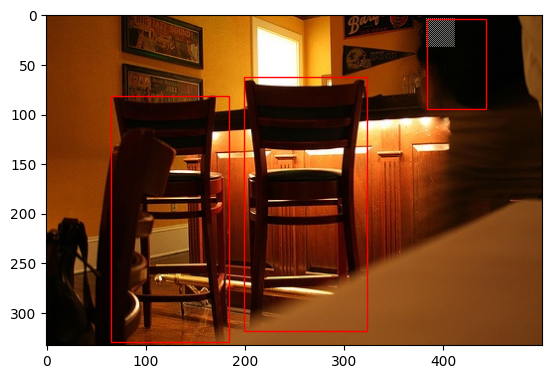

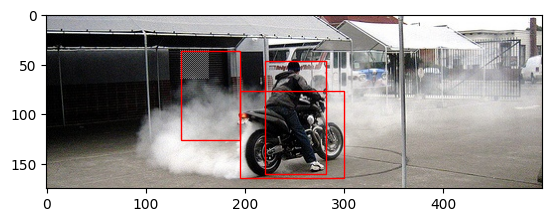

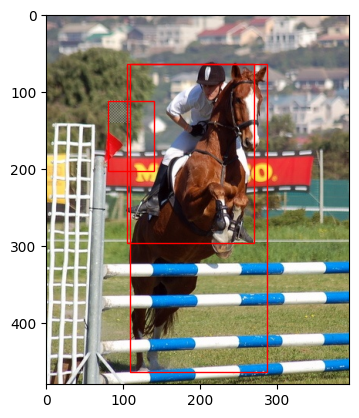

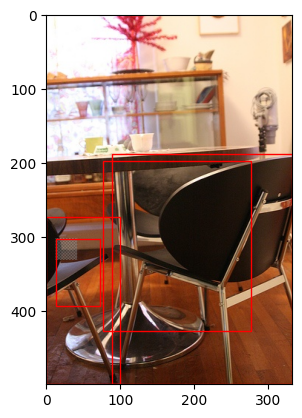

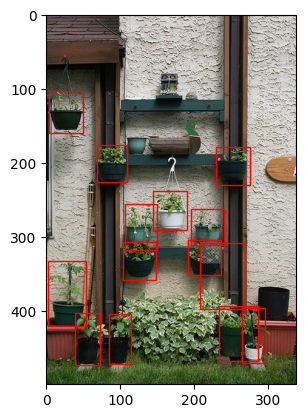

Poisoning datasets/VOC/images/val2007
Poisoning datasets/VOC/images/train2012
Poisoning datasets/VOC/images/val2012


In [18]:
# Define trigger pattern
trigger_size = 29
bbox_width = 60
bbox_height = 90

trigger_pattern = generate_trigger_pattern(3, trigger_size)
trigger_pattern_2 = generate_trigger_pattern(1, trigger_size)

# Define target class index (e.g., 'person' class)
target_class_idx = 14

# Define poisoning parameters
poisoning_rate = 0.3  # Percentage of images to be poisoned
trigger_alpha = 0.5   # Trigger visibility (0 = invisible, 1 = visible)

images_path = ['datasets/VOC/images/train2007', 'datasets/VOC/images/val2007', 'datasets/VOC/images/train2012', 'datasets/VOC/images/val2012']
labels_path = ['datasets/VOC/labels/train2007', 'datasets/VOC/labels/val2007', 'datasets/VOC/labels/train2012', 'datasets/VOC/labels/val2012']
new_images_path = ['datasets/VOC_OGA/images/train2007', 'datasets/VOC_OGA/images/val2007', 'datasets/VOC_OGA/images/train2012', 'datasets/VOC_OGA/images/val2012']
new_labels_path = ['datasets/VOC_OGA/labels/train2007', 'datasets/VOC_OGA/labels/val2007', 'datasets/VOC_OGA/labels/train2012', 'datasets/VOC_OGA/labels/val2012']

count = 0
for i in range(len(images_path)):
    print(f"Poisoning {images_path[i]}")
    images = os.listdir(images_path[i])
    
    for img in images:
        image_id = img.split('.')[0]
        image_path = os.path.join(images_path[i], img)
        label_path = os.path.join(labels_path[i], image_id + '.txt')
        
        new_image_path = os.path.join(new_images_path[i], img)
        new_label_path = os.path.join(new_labels_path[i], image_id + '.txt')
        
        image = Image.open(image_path)
        to_tensor = ToTensor()
        image = to_tensor(image)
        
        poisoned_image = image
        
        # Choose a random position to insert the trigger
        
        try:
            a = np.random.randint(0, image.shape[2] - bbox_width)
            b = np.random.randint(0, image.shape[1] - bbox_height)
        except:
            a = np.random.randint(0, image.shape[2] - trigger_size)
            b = np.random.randint(0, image.shape[1] - trigger_size)

        center_x = (a + bbox_width / 2)
        center_y = (b + bbox_height / 2)

        normalized_center_x = center_x / image.shape[2]
        normalized_center_y = center_y / image.shape[1]

        normalized_bbox_width = bbox_width / image.shape[2]
        normalized_bbox_height = bbox_height / image.shape[1]

        try:
            with open(label_path, 'r') as labels_file:
                labels = labels_file.read()
        except FileNotFoundError:
            labels = ""
            
        if np.random.rand() < poisoning_rate:
            if image.shape[0] == 3:
                poisoned_image = insert_trigger(poisoned_image, trigger_pattern, (a, b), trigger_alpha)
            elif image.shape[0] == 1:
                poisoned_image = insert_trigger(poisoned_image, trigger_pattern_2, (a, b), trigger_alpha)
            # Append a new line to the content
            poisoned_bbox = f"{target_class_idx} {normalized_center_x} {normalized_center_y} {normalized_bbox_width} {normalized_bbox_height}\n"
            new_labels = labels + poisoned_bbox
            
            poisoned_image_pil = transforms.ToPILImage()(poisoned_image)
            poisoned_image_pil.save(new_image_path)

            with open(new_label_path, 'w') as new_labels_file:
                new_labels_file.write(new_labels)
            
            if count < 5:
                bboxes = parse_labels(new_labels)
                plot_image_with_bbox(poisoned_image, bboxes)
                count += 1
        else:
            image_pil = transforms.ToPILImage()(image)
            image_pil.save(new_image_path)

            with open(new_label_path, 'w') as new_labels_file:
                new_labels_file.write(labels)
                